Importing modules

In [1]:
%matplotlib inline
import numpy as np

import sys, os
import FrequencyArray
import FastGB as FB
import matplotlib.pyplot as plt

import LISAConstants as LC

from LISAhdf5 import LISAhdf5,ParsUnits,Str

DirScript = '../software/LDCpipeline/scripts/'
### We go to the directory DirScript and run everything from there
os.chdir(DirScript)

Auxiliary Function

In [2]:
def GenerateFastGB(p):
    Amp = p.get("Amplitude")
    f0 = p.get("Frequency")
    fdot = p.get("FrequencyDerivative")
    iota = p.get("Inclination")
    psi = p.get("Polarization")
    phi0 = p.get("InitialPhase")
    EclLat = p.getConvert('EclipticLatitude',LC.convAngle,'rad')
    EclLon = p.getConvert('EclipticLongitude',LC.convAngle,'rad')

    Tobs = float(p.get("ObservationDuration"))
    del_t = float(p.get("Cadence"))
    print (Tobs, del_t)
    Ns = len(Amp)
    print ("FOund ", Ns, "source(s)")
    fastB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")
    prm = []
    if (Ns ==1):
        prm = np.array([f0[0], fdot[0], EclLat[0], EclLon[0], Amp[0], iota[0], psi[0], phi0[0]])
    else:
        for i in range(Ns):
            tmp = np.array([f0[i], fdot[i], EclLat[i], EclLon[i], Amp[i], iota[i], psi[i], phi0[i]])
            prm.append(tmp)
    print (prm)
    if (Ns == 1):
        Xf, Yf, Zf = fastB.onefourier(simulator='synthlisa', params=prm, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
    Xt = Xf.ifft(del_t)
    Yt = Yf.ifft(del_t)
    Zt = Zf.ifft(del_t)
    tm = np.arange(len(Xt))*del_t

    return(tm, Xt, Yt, Zt)


### Specify Parameter file, seed and specify hdf5-file

In [3]:
seed = 3
parFile = "ParamGal.txt"
#parFile = "ParamsTestGB.txt"
if not os.path.isfile(parFile):
    parser.error("par file "+parFile+" not found!")
fNh5 = "GB_exmpl.hdf5"

### Choose the source from the catalogue

In [4]:
os.system("python3 ChooseSources.py --verbose --paramFile="+parFile+"  --filename=" + fNh5 + " --seed=" + str(seed))
os.system("./LISAh5_display.py "+ fNh5)

0

### Generate the signal using FastGB (approx. response)

In [5]:
fr_hf5 = fNh5[:-5]+"_FD.hdf5"
#print (fr_hf5)
os.system("cp  " + fNh5 + "  " + fr_hf5 )
FD5 = LISAhdf5(fr_hf5)
NSrc = FD5.getSourcesNum()
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % NSrc, GWs)
### TODO make sure GalBin is there
if (GWs[0] != 'GalBinaries'):
    raise NotImplementedError
p = FD5.getSourceParameters(GWs[0])
p.display()

tm, Xt, Yt, Zt = GenerateFastGB(p)

Found 1 GW sources:  ['GalBinaries']
	Amplitude [  1.78922991e-22] [strain]
	Cadence 15.0 [Seconds]
	EclipticLatitude [ 0.47411433] [Radian]
	EclipticLongitude [ 5.19921] [Radian]
	Frequency [ 0.00099303] [Hz]
	FrequencyDerivative [  1.39737000e-18] [Hz^2]
	Inclination [ 0.1793956] [Radian]
	InitialPhase [ 5.781211] [Radian]
	ObservationDuration 41943040.0 [Seconds]
	Polarization [ 3.975816] [Radian]

41943040.0 15.0
FOund  1 source(s)
[  9.93034853e-04   1.39737000e-18   4.74114327e-01   5.19921000e+00
   1.78922991e-22   1.79395600e-01   3.97581600e+00   5.78121100e+00]


### Generate the signal using LISACode

In [6]:
### Compute h+, hx
os.system("python3 Compute_hphc.py  " + fNh5)

fh5 = LISAhdf5(fNh5)
NSrc = fh5.getSourcesNum()
GWs = fh5.getSourcesName()
GW = "GalBinaries"
p = fh5.getSourceParameters(GW)
dt = p.get("Cadence")
dur = p.get("ObservationDuration")

####  Configure the LISA:
print ("Configure Instrument")
os.system("python3 ConfigureInstrument.py  --duration="+str(dur)+"  --timeStep="+ str(dt) +"  --orbits='MLDC_Orbits'  " + fNh5)

####  Configure the Noises
print ("Configure Noises")
os.system("python3 ConfigureNoises.py  " + fNh5)
print ("done")
### Pass through the simulator

os.system("python3 RunSimuLC2.py --NoNoise --seed=" + str(seed) + "  -v  "  + fNh5)


Configure Instrument
Configure Noises
done


256

### read and plot h+

[  0.00000000e+00   1.50000000e+01   3.00000000e+01 ...,   4.19429850e+07
   4.19430000e+07   4.19430150e+07]
[ -1.38512498e-22  -1.07653619e-22  -7.58524540e-23 ...,  -3.44631918e-22
  -3.36380776e-22  -3.25185311e-22]
[  3.23752789e-22   3.35282976e-22   3.43878450e-22 ...,   7.21516760e-23
   1.04047706e-22   1.35033013e-22]


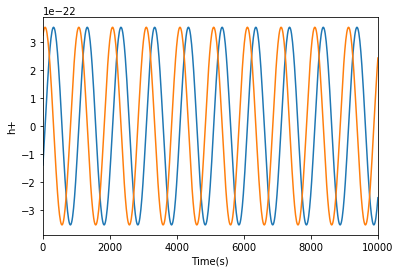

In [8]:
TD5 = LISAhdf5(fNh5)
thphc = TD5.getSourceHpHc('GalBinaries')
tm = thphc[0][0]
hp = thphc[1][0]
hc = thphc[2][0]

plt.plot(tm,hp)
plt.plot(tm,hc)
plt.xlabel('Time(s)')
plt.ylabel('h+')
plt.xlim([0.0, 10000])
plt.show()

### Reading hdf5 files and plotting the TDIs

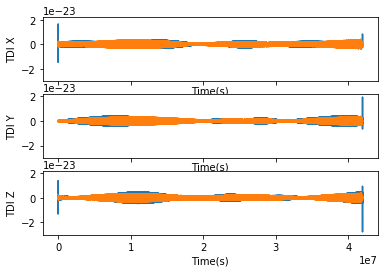

In [9]:
TD5 = LISAhdf5(fNh5)
td = TD5.getPreProcessTDI()
fig, ax = plt.subplots(3, sharex=True, sharey=True)
ax[0].plot(td[:,0], td[:,1])
ax[0].plot(tm, Xt, "--")
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('TDI X')
#ax[0].set_xlim([2.494e7, 2.498e7])
#ax[0].set_ylim([-1.e-20, 1.e-20])
#ax[0].legend(loc=4)

ax[1].plot(td[:,0], td[:,2])
ax[1].plot(tm, Yt, "--")
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('TDI Y')

ax[2].plot(td[:,0], td[:,3])
ax[2].plot(tm, Zt, "--")
ax[2].set_xlabel('Time(s)')
ax[2].set_ylabel('TDI Z')
plt.show()
